# Car detection project

### 1. Load packages

In [2]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set_style('whitegrid')

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import pickle

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [4]:
from keras import backend as K
K.set_image_data_format('channels_last')

In [5]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

### 2. Define functions for a model

In [5]:
# Using VGG16

from keras.applications.vgg16 import VGG16

def load_vgg16(weights_path='../vgg_weights/vgg16_weights_tf_no_top.h5'):
    
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224, 224, 3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.load_weights(weights_path)
    
    return model

In [6]:
model = load_vgg16(weights_path='../vgg_weights/vgg16_weights_tf_no_top.h5')
model.summary()

C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), act

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)    

In [15]:
# Using bottleneck features for better memory consumption

def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=1, 
                                            class_mode=None, 
                                            shuffle=False) 
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    #np.save(open(location+'/bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    pickle.dump(bottleneck_features_train, open(location+'/bottleneck_features_train.pickle', 'wb'))
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=1,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    pickle.dump(bottleneck_features_validation, open(location+'/bottleneck_features_validation.pickle', 'wb'))

In [16]:
# Metric plotting function

def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print ("Best Model:")
    print_best_model_results(hist)

In [19]:
# Training

def train_binary_model():

    #train_data = np.load(open(location+'/bottleneck_features_train.npy'))
    train_data = pickle.load(open(location+'/bottleneck_features_train.pickle', 'rb'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    #validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_data = pickle.load(open(location+'/bottleneck_features_validation.pickle', 'rb'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', W_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation = 'sigmoid')) # should activation be sigmoid for binary problem?

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    #with open(location+'/top_history.txt', 'wb') as f:
        #json.dump(fit.history, f)
        
    pickle.dump(fit.history, open(location+'/top_history.pickle', 'wb'))
    
    return model, fit.history

In [20]:
# Finetuning the final model

def finetune_binary_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', W_regularizer=l2(0.001)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1,
                              callbacks=[checkpoint])
    
    pickle.dump(fit.history, open(location+'/ft_history.pickle', 'wb'))
    
    return model, fit.history

In [21]:
# See some results

def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print ('')
    print (classification_report(validation_labels, pred_labels))
    print ('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [22]:
# See results for every photo

def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [23]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print ('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

### 3. Testing Image Generation

In [36]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest') # omitted rescaling to keep the images displayable

img = load_img('../data/detect_cars/training/cars/0040.jpg') # this is a PIL image 
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
os.makedirs('preview')
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='preview', save_prefix='car',
                         save_format='jpg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

### 4. Fit the data

In [6]:
# Path to the model weights file
location = '../data'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# Dimensions of our images
img_width, img_height = 224, 224

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [25]:
# Generate bottleneck features
save_bottleneck_features(location)

C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), act

Found 4138 images belonging to 2 classes.

Found 1231 images belonging to 2 classes.


In [26]:
d1a_model1, d1a_history1 = train_binary_model()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4138 samples, validate on 1231 samples
Epoch 1/50
4138/4138 [==============================] - 6s 1ms/step - loss: 0.9087 - accuracy: 0.8221 - val_loss: 0.7423 - val_accuracy: 0.9269

Epoch 00001: val_accuracy improved from -inf to 0.92689, saving model to ../data/data0a/top_model_weights.h5
Epoch 2/50
4138/4138 [==============================] - 4s 1ms/step - loss: 0.7475 - accuracy: 0.9091 - val_loss: 0.6867 - val_accuracy: 0.9439

Epoch 00002: val_accuracy improved from 0.92689 to 0.94395, saving model to ../data/data0a/top_model_weights.h5
Epoch 3/50
4138/4138 [==============================] - 4s 1ms/step - loss: 0.7016 - accuracy: 0.9311 - val_loss: 0.6890 - val_accuracy: 0.9423

Epoch 00003: val_accuracy did not improve from 0.94395
Epoch 4/50
4138/4138 [==============================] - 4s 1ms/step - loss: 0.6762 - accuracy: 0.9422 - val_loss: 0.6553 - val_accuracy: 0.9480

Epoch 00004: val_accuracy improved from 0.94395 to 0.94801, saving model to ../data/data0a/top_m

4138/4138 [==============================] - 4s 1ms/step - loss: 0.5313 - accuracy: 0.9896 - val_loss: 0.5902 - val_accuracy: 0.9699

Epoch 00039: val_accuracy did not improve from 0.96994
Epoch 40/50
4138/4138 [==============================] - 4s 1ms/step - loss: 0.5277 - accuracy: 0.9896 - val_loss: 0.5923 - val_accuracy: 0.9699

Epoch 00040: val_accuracy did not improve from 0.96994
Epoch 41/50
4138/4138 [==============================] - 4s 1ms/step - loss: 0.5274 - accuracy: 0.9894 - val_loss: 0.5891 - val_accuracy: 0.9675

Epoch 00041: val_accuracy did not improve from 0.96994
Epoch 42/50
4138/4138 [==============================] - 4s 1ms/step - loss: 0.5251 - accuracy: 0.9913 - val_loss: 0.5880 - val_accuracy: 0.9667

Epoch 00042: val_accuracy did not improve from 0.96994
Epoch 43/50
4138/4138 [==============================] - 4s 1ms/step - loss: 0.5218 - accuracy: 0.9923 - val_loss: 0.5926 - val_accuracy: 0.9699

Epoch 00043: val_accuracy did not improve from 0.96994
Epoch 4

### 5. Metrics of the model

Best Model:
epoch: 47 , val_acc: 0.9715678095817566 , val_loss: 0.5860006455770844


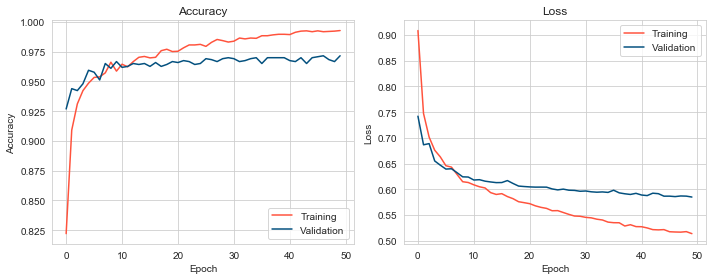

In [28]:
# Let's see the first results

plot_metrics(d1a_history1) # rmsprop, sigmoid, no regularization

### 6. Fine Tuning

In [ ]:
nb_epoch = 50
ft_model, ft_history = finetune_binary_model()

C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), act

Found 4138 images belonging to 2 classes.
Found 1231 images belonging to 2 classes.


C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:60: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\ProgramData\Anaconda3\envs\py37_test\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=517, epochs=50, validation_steps=1231)`


Epoch 1/50
517/517 [==============================] - 171s 331ms/step - loss: 0.6755 - accuracy: 0.9235 - val_loss: 0.4884 - val_accuracy: 0.9675

Epoch 00001: val_accuracy improved from -inf to 0.96748, saving model to ../data/data0a/ft_model.h5
Epoch 2/50
517/517 [==============================] - 175s 339ms/step - loss: 0.6553 - accuracy: 0.9354 - val_loss: 0.5035 - val_accuracy: 0.9618

Epoch 00002: val_accuracy did not improve from 0.96748
Epoch 3/50
517/517 [==============================] - 174s 337ms/step - loss: 0.6538 - accuracy: 0.9354 - val_loss: 0.4965 - val_accuracy: 0.9718

Epoch 00003: val_accuracy improved from 0.96748 to 0.97185, saving model to ../data/data0a/ft_model.h5
Epoch 4/50
517/517 [==============================] - 172s 333ms/step - loss: 0.6397 - accuracy: 0.9426 - val_loss: 0.5927 - val_accuracy: 0.9712

Epoch 00004: val_accuracy did not improve from 0.97185
Epoch 5/50
517/517 [==============================] - 174s 337ms/step - loss: 0.6392 - accuracy: 0.

### 7. Metrics of the finetuned model

Best Model:
epoch: 46 , val_acc: 0.9309210777282715 , val_loss: 0.5176084041595459


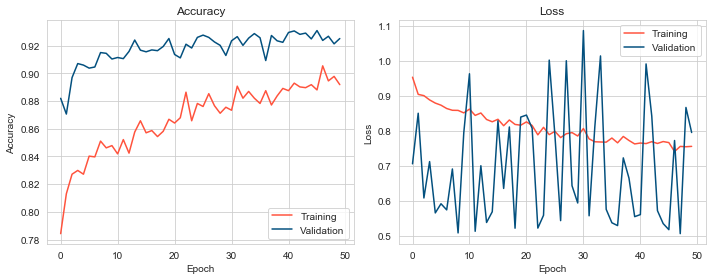

In [86]:
plot_metrics(ft_history)

### 8. Confusion matrix

In [7]:
# Load the finetuned model

ft_model = load_model(location+'/ft_model.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [29]:
validation_data = pickle.load(open(location+'/bottleneck_features_validation.pickle', 'rb'))
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1])
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 1231 images belonging to 2 classes.

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       460
           1       0.98      0.98      0.98       771

    accuracy                           0.98      1231
   macro avg       0.98      0.98      0.98      1231
weighted avg       0.98      0.98      0.98      1231




In [30]:
heatmap_labels = ['Car', 'Other']

(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

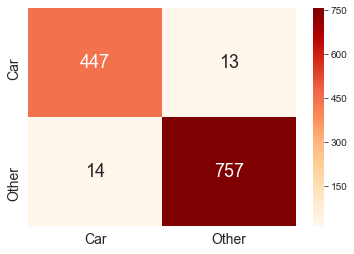

In [31]:
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

ax.set_ylim(2.0, 0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax.set(yticks=[0, 2.0])